### This set of image data has been extracted from the __`YouTube Faces Dataset`__, which includes videos of people in YouTube videos.

#### These videos have been fed through some processing steps and turned into sets of image frames containing one face and the associated keypoints.

#### This facial keypoints dataset consists of 5770 color images. All of these images are separated into either a training or a test set of data.

In [49]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import random
from sklearn.model_selection import train_test_split
from efficientnet_pytorch import EfficientNet

# Read training data

In [50]:
# Reading data
key_points_frame = pd.read_csv('input/data/training_frames_keypoints.csv')
key_points_frame.rename(columns={'Unnamed: 0': 'file_name'}, inplace=True)

key_points_frame.head()

,file_name,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


# Display some information about the data

In [4]:
# Display one image statistics for better understanding
n = 0
image_name = key_points_frame.iloc[n,0]
key_points = (key_points_frame.iloc[n,1:]).to_numpy()
key_points = key_points.astype('float').reshape(-1,2)

print(f"Image name: {image_name}")
print(f"Landmarks shape: {key_points.shape}")
print(f"First 5 key points:\n{key_points[:5]}")

Image name: Luis_Fonsi_21.jpg
Landmarks shape: (68, 2)
First 5 key points:
[[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]
 [ 56. 125.]]


# Look at images with keypoints

#### Below there is a function __show_keypoints__, that takes in an image and keypoints and displays them.

In [5]:
def show_keypoints(image, key_points):
    """Show images with keypoints"""
    plt.imshow(image)
    plt.scatter(key_points[:, 0], key_points[:, 1], s=20, c='b')

#### As these images are not all of the same size (and neither are the faces), we will need to standartize their shape to train a NN.

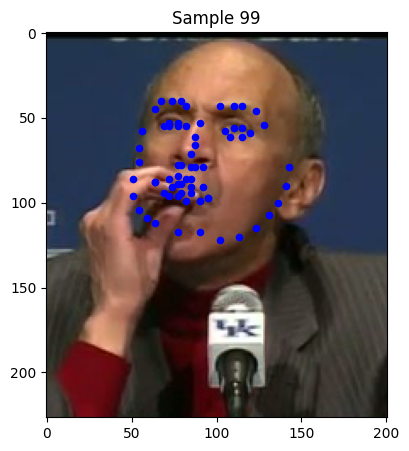

In [6]:
# Display different images by changing the index
index = 99

image_name = key_points_frame.iloc[index, 0]
key_points = key_points_frame.iloc[index, 1:].to_numpy()
key_points = key_points.astype('float').reshape(-1,2)

plt.figure(figsize=(5,5))
show_keypoints(mpimg.imread(os.path.join('input/data/training/', image_name)), key_points)
plt.title(f'Sample {index}')
plt.show()

# Dataset

In [51]:
class FaceKeypointsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.key_points_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_points_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir, self.key_points_frame.iloc[idx, 0])
        image = mpimg.imread(image_name)

        if image.ndim == 2:
            image = np.stack((image,) * 3, axis=-1)
        elif image.shape[2] == 4:
            image = image[:, :, :3]

        key_points = self.key_points_frame.iloc[idx, 1:].to_numpy()
        key_points = key_points.astype('float').reshape(-1, 2)

        sample = {'image': image, 'keypoints': key_points}

        if self.transform:
            sample = self.transform(sample)

        return sample


# Transformations

In [52]:
class RandomRotation(object):
    """Randomly rotate the image."""

    def __init__(self, degrees=90):
        self.degrees = degrees

    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        angle = random.uniform(-self.degrees, self.degrees)
        rotation_mat = cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, 1)
        rotated_image = cv2.warpAffine(image, rotation_mat, (image.shape[1], image.shape[0]))
        ones = np.ones(shape=(len(key_points), 1))
        points_ones = np.hstack([key_points, ones])
        transformed_keypoints = rotation_mat.dot(points_ones.T).T
        return {'image': rotated_image, 'keypoints': transformed_keypoints}

class AddNoise(object):
    """Add random noise to the image."""

    def __init__(self, noise_level=0.1):
        self.noise_level = noise_level

    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        noise = np.random.normal(scale=self.noise_level, size=image.shape)
        noisy_image = image + noise
        noisy_image = np.clip(noisy_image, 0, 255)
        return {'image': noisy_image.astype(np.uint8), 'keypoints': key_points}

class Normalize(object):
    """Normaliza image and keypoints."""
    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        return {'image': image / 255.0, 'keypoints': key_points / [w, h]}

class Rescale(object):
    """Rescale image to required size."""
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = cv2.resize(image, (new_w, new_h))
        key_points = key_points * [new_w / w, new_h / h]
        return {'image': img, 'keypoints': key_points}

class ToTensor(object):
    """Convert to tensor."""
    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        if len(image.shape) == 2:
            image = image.reshape(image.shape[0], image.shape[1], 1)
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image), 'keypoints': torch.from_numpy(key_points)}

class RandomBrightnessContrast(object):
    """Randomly change brightness and contrast."""
    def __init__(self, brightness=0.2, contrast=0.2):
        self.brightness = brightness
        self.contrast = contrast

    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        brightness_factor = 1.0 + random.uniform(-self.brightness, self.brightness)
        contrast_factor = 1.0 + random.uniform(-self.contrast, self.contrast)
        image = cv2.convertScaleAbs(image, alpha=contrast_factor, beta=brightness_factor * 50)
        return {'image': image, 'keypoints': key_points}

class RandomScale(object):
    """Randomly scale the image."""
    def __init__(self, scale_range=(0.8, 1.2)):
        self.scale_range = scale_range

    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        scale = random.uniform(*self.scale_range)
        new_h, new_w = int(h * scale), int(w * scale)
        image = cv2.resize(image, (new_w, new_h))
        key_points = key_points * [new_w / w, new_h / h]
        return {'image': image, 'keypoints': key_points}

class RandomHorizontalFlip(object):
    """Randomly flip the image horizontally."""
    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        if random.random() > 0.5:
            image = np.fliplr(image).copy()
            key_points[:, 0] = image.shape[1] - key_points[:, 0]
        return {'image': image, 'keypoints': key_points}

class RandomVerticalFlip(object):
    """Randomly flip the image vertically."""
    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        if random.random() > 0.5:
            image = np.flipud(image).copy()
            key_points[:, 1] = image.shape[0] - key_points[:, 1]
        return {'image': image, 'keypoints': key_points}

class RandomCrop(object):
    """Randomly crop the image."""
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        image = image[top: top + new_h, left: left + new_w]
        key_points = key_points - [left, top]
        return {'image': image, 'keypoints': key_points}

In [53]:
# Transforms for training data with augmentations
train_transform = transforms.Compose([
    Rescale((256, 256)),
    RandomCrop((224, 224)),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    RandomRotation(degrees=30),
    AddNoise(noise_level=5),
    RandomBrightnessContrast(),
    RandomScale(),
    Normalize(),
    ToTensor()
])

# Transforms for validation and test data (without augmentations)
test_transform = transforms.Compose([
    Rescale((224, 224)),
    Normalize(),
    ToTensor()
])

# Datasets and DataLoaders

In [54]:
# Create the full dataset
full_dataset = FaceKeypointsDataset(csv_file='input/data/training_frames_keypoints.csv', root_dir='input/data/training/', transform=None)

# Split the dataset into training and validation sets
train_idx, val_idx = train_test_split(np.arange(len(full_dataset)), test_size=0.2, random_state=26)

# Create training and validation subsets
train_subset = Subset(full_dataset, train_idx)
val_subset = Subset(full_dataset, val_idx)


# Apply transforms to the training and validation subsets
train_subset.dataset.transform = train_transform
val_subset.dataset.transform = test_transform


# Create DataLoaders for training and validation
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

# Create the test dataset and DataLoader
test_dataset = FaceKeypointsDataset(csv_file='input/data/test_frames_keypoints.csv', root_dir='input/data/test/', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### We are going to use __`pretrained models (ResNet, EfficientNet, MobileNet)`__ for facial 68 landmarks predictions by removing the last layer, adding 1 adaptive pooling layer and 2 fully-connected layers. 
### So, we will train them on our new data, evaluate and visualize the results obtained, hoping they would be better, than of custom CNN performed earlier.

# 1. ResNet

In [55]:
class ResNetKeypoints(nn.Module):
    def __init__(self, num_keypoints=68):
        super(ResNetKeypoints, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-2])

        # Add an adaptive pooling layer
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Calculate the input size for the first fully connected layer
        self.fc1 = nn.Linear(resnet.fc.in_features, 1024)
        self.fc2 = nn.Linear(1024, num_keypoints * 2)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        # convert to range [0, 1]
        x = torch.sigmoid(x)
        return x

# Training

In [17]:
# Function for training
def train_net(model, criterion, optimizer, train_loader, val_loader, n_epochs, device):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_epoch = 0

    for epoch in range(n_epochs):
        model.train()
        running_train_loss = 0.0
        for batch in train_loader:
            images, keypoints = batch['image'], batch['keypoints']
            images, keypoints = images.to(device).float(), keypoints.to(device).float()
            keypoints = keypoints.view(keypoints.size(0), -1)  # shape (batch_size, 136)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, keypoints)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                images, keypoints = batch['image'], batch['keypoints']
                images, keypoints = images.to(device).float(), keypoints.to(device).float()
                keypoints = keypoints.view(keypoints.size(0), -1)  # shape (batch_size, 136)

                outputs = model(images)
                loss = criterion(outputs, keypoints)

                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model.pth')

    return train_losses, val_losses, best_epoch

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = ResNetKeypoints().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


In [14]:
n_epochs = 8
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train_losses, val_losses, best_epoch = train_net(model, criterion, optimizer, train_loader, val_loader, n_epochs, device)

Epoch 1/8, Train Loss: 0.0018, Val Loss: 0.0023
Epoch 2/8, Train Loss: 0.0005, Val Loss: 0.0006
Epoch 3/8, Train Loss: 0.0004, Val Loss: 0.0003
Epoch 4/8, Train Loss: 0.0003, Val Loss: 0.0003
Epoch 5/8, Train Loss: 0.0003, Val Loss: 0.0003
Epoch 6/8, Train Loss: 0.0003, Val Loss: 0.0002
Epoch 7/8, Train Loss: 0.0003, Val Loss: 0.0004
Epoch 8/8, Train Loss: 0.0003, Val Loss: 0.0005


# Learning curve

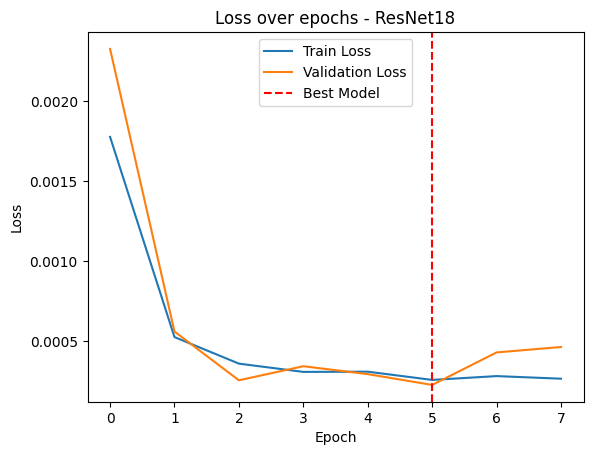

In [ ]:
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axvline(best_epoch, color='r', linestyle='--', label='Best Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs - ResNet18')
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/best_model_mobilenet.pth')

# Load model

In [58]:
# load best model
model.load_state_dict(torch.load('models/best_model_mobilenet.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

# Evaluation

In [59]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for batch in test_loader:
            images, keypoints = batch['image'], batch['keypoints']
            images, keypoints = images.to(device).float(), keypoints.to(device).float()
            keypoints = keypoints.view(keypoints.size(0), -1)  # shape (batch_size, 136)

            outputs = model(images)
            loss = criterion(outputs, keypoints)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_loss:.4f}')
    return avg_loss

In [ ]:
# evaluate on test data
test_loss = evaluate_model(model, test_loader, criterion, device)

Test Loss: 0.0004


# Visualization

In [94]:
def show_keypoints(ax, image, predicted_keypoints=None, actual_keypoints=None):
    height, width = image.shape[:2]
    ax.imshow(image)
    if actual_keypoints is not None:
        actual_keypoints = actual_keypoints * [width, height]
        ax.scatter(actual_keypoints[:, 0], actual_keypoints[:, 1], s=50, marker='o', c='g', label='Actual')
    if predicted_keypoints is not None:
        predicted_keypoints = predicted_keypoints * [width, height]
        ax.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], s=50, marker='x', c='r', label='Predicted')
    ax.legend()
    ax.axis('off')

In [96]:
def visualize_predictions(dataset, model, device, num_images=6, images_per_row=3):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)
    rows = num_images // images_per_row + int(num_images % images_per_row != 0)
    fig, axs = plt.subplots(rows, images_per_row, figsize=(20, 10))

    axs = axs.flatten()

    with torch.no_grad():
        for i, idx in enumerate(indices):
            sample = dataset[idx]
            image = sample['image'].unsqueeze(0).to(device).float()
            outputs = model(image)
            predicted_keypoints = outputs.view(-1, 2).cpu().numpy()
            actual_keypoints = sample['keypoints'].numpy()
            image = sample['image'].permute(1, 2, 0).numpy() * 255

            show_keypoints(axs[i], image, predicted_keypoints, actual_keypoints)

        for j in range(i + 1, len(axs)):
            fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

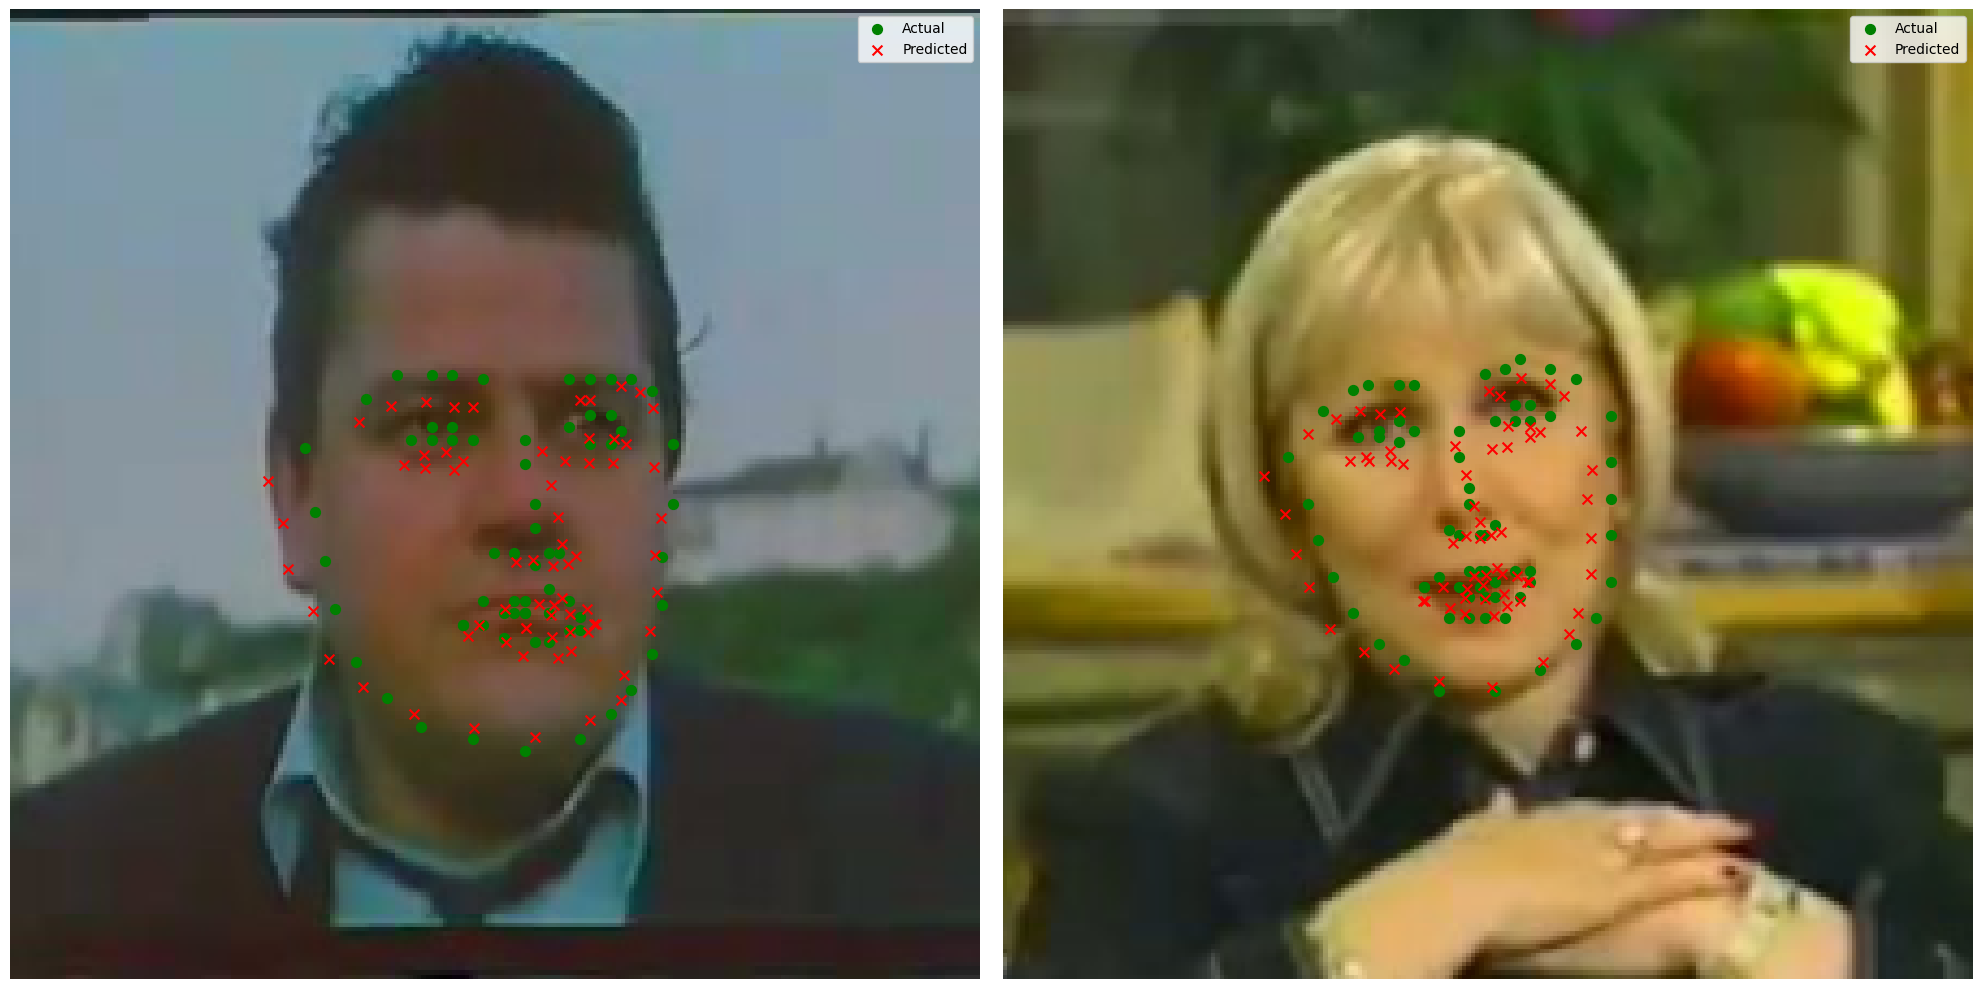

In [ ]:
# Call the function to visualize predictions
visualize_predictions(test_dataset, model, device, num_images=2, images_per_row=2)

# 2. EfficientNet

In [121]:
class EfficientNetKeypoints(nn.Module):
    def __init__(self, num_keypoints=68):
        super(EfficientNetKeypoints, self).__init__()
        efficientnet = EfficientNet.from_pretrained('efficientnet-b0').to(device)
        self.features = efficientnet.extract_features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(efficientnet._fc.in_features, 1024)
        self.fc2 = nn.Linear(1024, num_keypoints * 2)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        # convert to range [0, 1]
        x = torch.sigmoid(x)
        return x

In [ ]:
# Instantiate the model and move it to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientNetKeypoints().to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 156MB/s] 


Loaded pretrained weights for efficientnet-b0


In [123]:
n_epochs = 8
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training

In [ ]:
train_losses, val_losses, best_epoch = train_net(model, criterion, optimizer, train_loader, val_loader, n_epochs, device)

Epoch 1/8, Train Loss: 0.0036, Val Loss: 0.0030
Epoch 2/8, Train Loss: 0.0027, Val Loss: 0.0028
Epoch 3/8, Train Loss: 0.0023, Val Loss: 0.0029
Epoch 4/8, Train Loss: 0.0020, Val Loss: 0.0027
Epoch 5/8, Train Loss: 0.0018, Val Loss: 0.0027
Epoch 6/8, Train Loss: 0.0015, Val Loss: 0.0027
Epoch 7/8, Train Loss: 0.0014, Val Loss: 0.0028
Epoch 8/8, Train Loss: 0.0012, Val Loss: 0.0027


# Learning curve

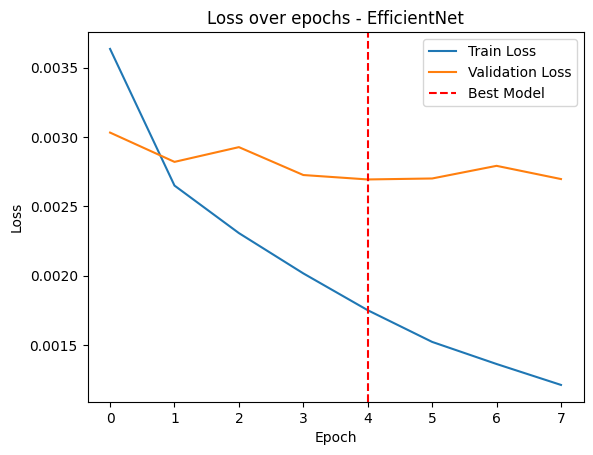

In [ ]:
# Loss on train and val sets
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axvline(best_epoch, color='r', linestyle='--', label='Best Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs - EfficientNet')
plt.show()

# Save model

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/best_model_efficientnet.pth')

In [ ]:
# load best model
model.load_state_dict(torch.load('/content/drive/My Drive/best_model_efficientnet.pth'))
model.to(device)

EfficientNetKeypoints(
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=1280, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=136, bias=True)
)

# Evaluation

In [ ]:
# evaluation on test data
test_loss = evaluate_model(model, test_loader, criterion, device)

Test Loss: 0.0019


# Visualization

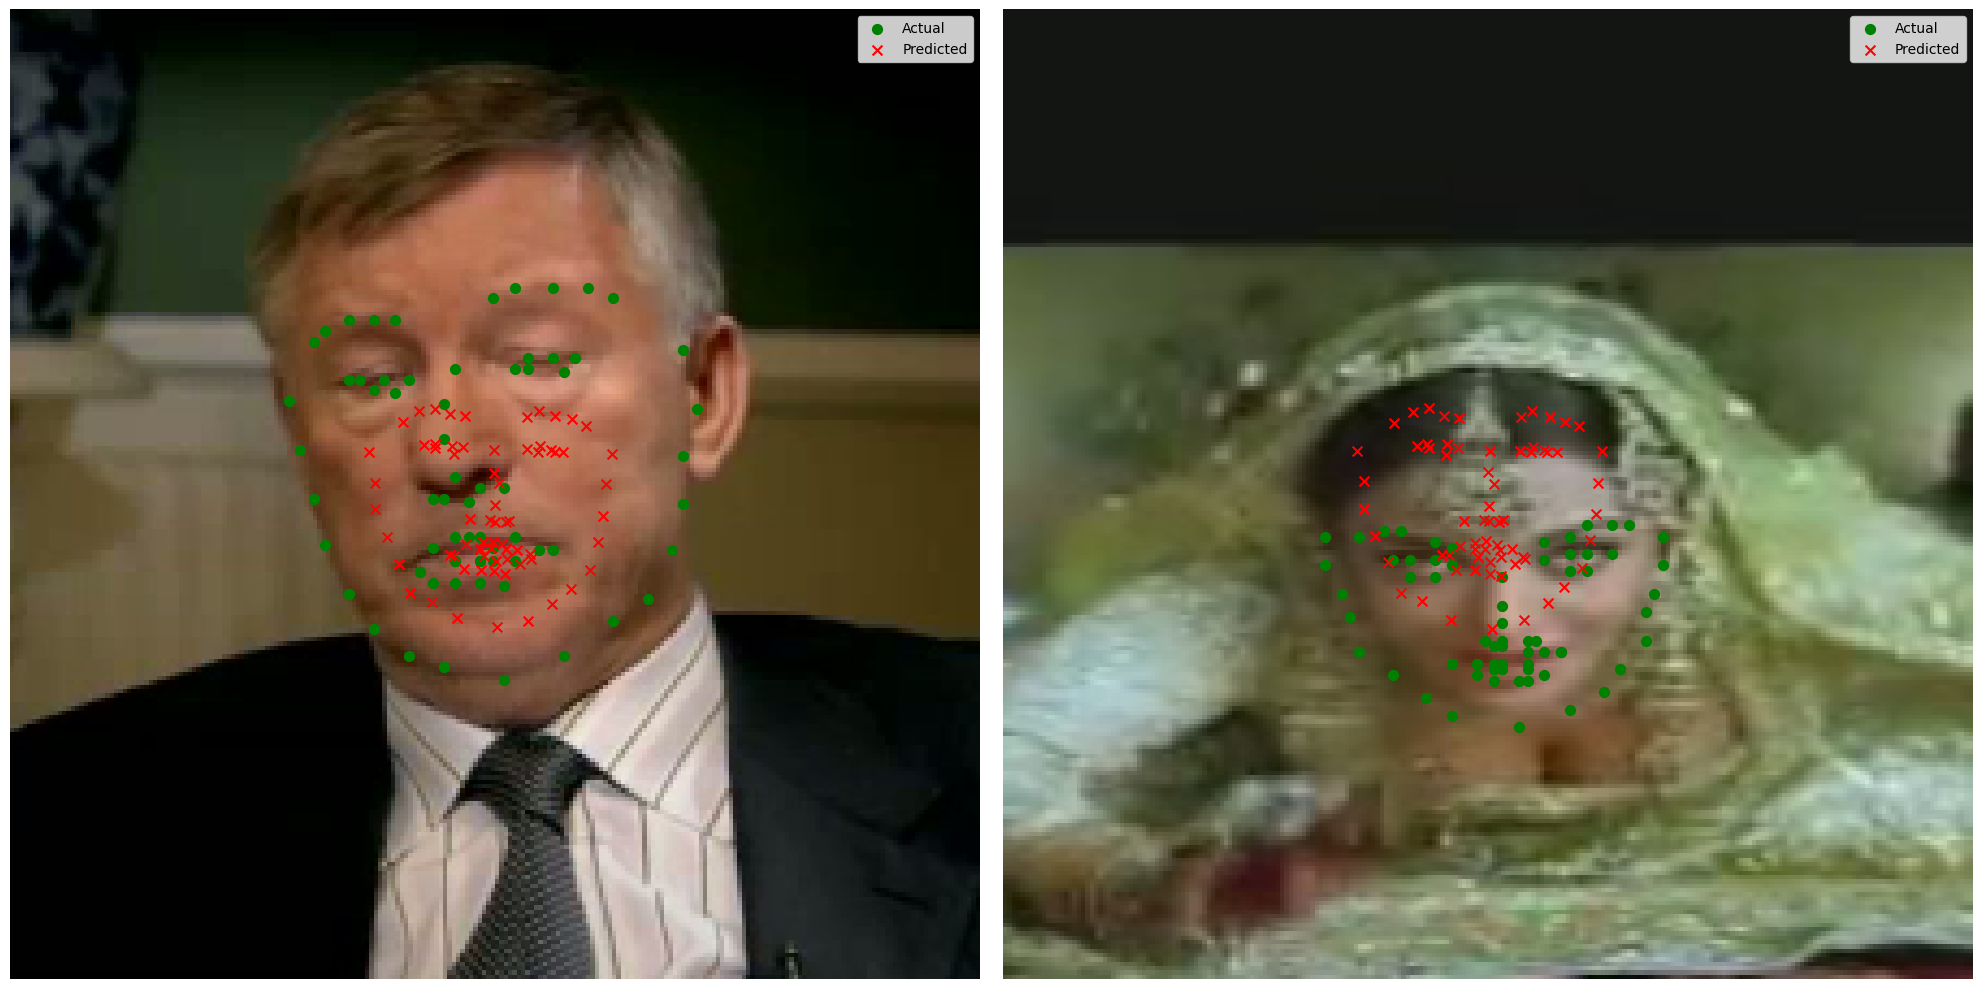

In [ ]:
# Call the function to visualize predictions
visualize_predictions(test_dataset, model, device, num_images=2, images_per_row=2)

> ### Really bad performance on these data.

# 3. MobileNetV2

In [164]:
class MobileNetV2Keypoints(nn.Module):
    def __init__(self, num_keypoints=68):
        super(MobileNetV2Keypoints, self).__init__()
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.features = mobilenet.features # extracts all convolutional layers from the pre-trained MobileNetV2 model
        self.pool = nn.AdaptiveAvgPool2d((1, 1)) # It is used for adaptive averaging by the size of the output from self.features to get a fixed size of 1x1, regardless of the size of the input image
        self.fc1 = nn.Linear(mobilenet.last_channel, 1024) # returns the number of channels of the last layer, which correctly corresponds to the input size for the self.fc1 layer
        self.fc2 = nn.Linear(1024, num_keypoints * 2)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

# Training

In [165]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = MobileNetV2Keypoints().to(device)

d:\IT\Anaconda\envs\new_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\IT\Anaconda\envs\new_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\ksush/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:06<00:00, 2.12MB/s]


In [162]:
n_epochs = 8
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train_losses, val_losses, best_epoch = train_net(model, criterion, optimizer, train_loader, val_loader, n_epochs, device)

Epoch 1/8, Train Loss: 0.0021, Val Loss: 0.0016
Epoch 2/8, Train Loss: 0.0006, Val Loss: 0.0013
Epoch 3/8, Train Loss: 0.0005, Val Loss: 0.0004
Epoch 4/8, Train Loss: 0.0004, Val Loss: 0.0006
Epoch 5/8, Train Loss: 0.0003, Val Loss: 0.0005
Epoch 6/8, Train Loss: 0.0003, Val Loss: 0.0003
Epoch 7/8, Train Loss: 0.0003, Val Loss: 0.0002
Epoch 8/8, Train Loss: 0.0003, Val Loss: 0.0004


# Learning curve

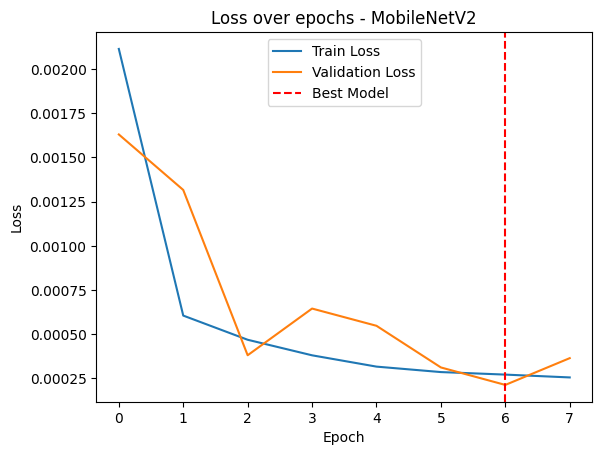

In [ ]:
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axvline(best_epoch, color='r', linestyle='--', label='Best Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs - MobileNetV2')
plt.show()

# Save model

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/best_model_mobilenet.pth')

In [ ]:
# load best model
model.load_state_dict(torch.load('models/best_model_mobilenet.pth'))

<All keys matched successfully>

# Evaluation

In [ ]:
# evaluate on test data
test_loss = evaluate_model(model, test_loader, criterion, device)

Test Loss: 0.0004


# Visualization

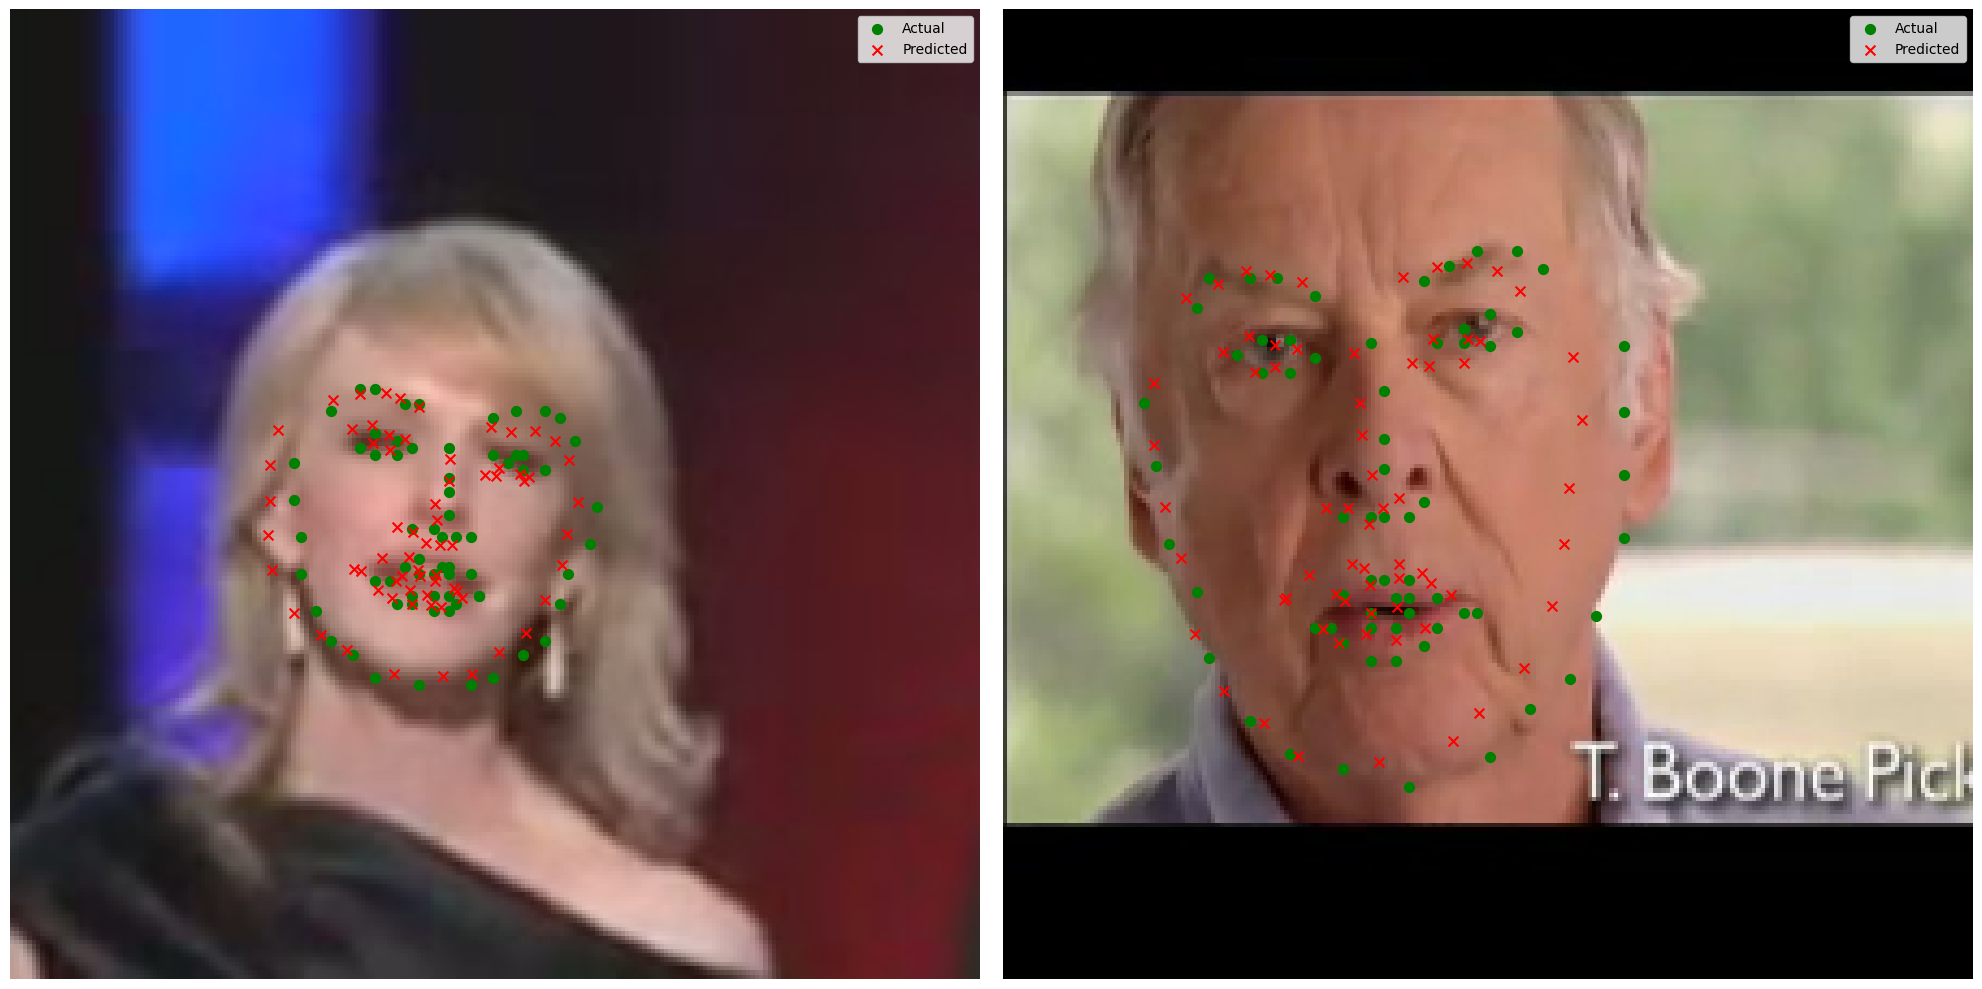

In [ ]:
# Call the function to visualize predictions
visualize_predictions(test_dataset, model, device, num_images=2, images_per_row=2)

# Conclusion:

### It's turned out pretrained __MobileNet__ and __ResNet18__ to be the best performing models with this data.

### But nevertheless, __`MobileNet`__ is the best model because it's faster and even gives a slightly more accurate result.

In [81]:
# load best model
model = ResNetKeypoints().to(device)

model.load_state_dict(torch.load('models/best_model_resnet.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

# Prediction of keypoints and visualization for my own photos that don't have actual landmarks

In [ ]:
class RescaleNoKeypoints(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = cv2.resize(image, (new_w, new_h))
        return {'image': img, 'image_path': sample['image_path']}

class NormalizeNoKeypoints(object):
    def __call__(self, sample):
        image = sample['image']
        image = image / 255.0
        return {'image': image, 'image_path': sample['image_path']}

class ToTensorNoKeypoints(object):
    def __call__(self, sample):
        image = sample['image']
        if len(image.shape) == 2:
            image = image.reshape(image.shape[0], image.shape[1], 1)
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image), 'image_path': sample['image_path']}


In [ ]:
test_transform_no_keypoints = transforms.Compose([
    RescaleNoKeypoints((224, 224)),
    NormalizeNoKeypoints(),
    ToTensorNoKeypoints()
])

In [ ]:
class FaceKeypointsDatasetNoLabels(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = mpimg.imread(image_path)

        if image.ndim == 2:
            image = np.stack((image,) * 3, axis=-1)
        elif image.shape[2] == 4:
            image = image[:, :, :3]

        sample = {'image': image, 'image_path': image_path}

        if self.transform:
            sample = self.transform(sample)

        return sample


In [ ]:
def predict_on_new_images(model, dataset, device):
    model.eval()
    results = []

    with torch.no_grad():
        for i in range(len(dataset)):
            sample = dataset[i]
            image = sample['image'].unsqueeze(0).to(device).float()
            image_path = sample['image_path']

            outputs = model(image)
            predicted_keypoints = outputs.view(-1, 2).cpu().numpy()

            results.append((image_path, predicted_keypoints))

    return results


In [ ]:
def visualize_predictions_no_labels(results, num_images=4, images_per_row=2):
    rows = num_images // images_per_row + int(num_images % images_per_row != 0)
    fig, axs = plt.subplots(rows, images_per_row, figsize=(20, 10))

    axs = axs.flatten()

    for i in range(num_images):
        image_path, predicted_keypoints = results[i]
        image = mpimg.imread(image_path)
        height, width = image.shape[:2]

        ax = axs[i]
        ax.imshow(image)
        predicted_keypoints = predicted_keypoints * [width, height]
        ax.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], s=20, marker='x', c='r', label='Predicted')
        ax.axis('off')

    plt.tight_layout()
    plt.legend()
    plt.show()


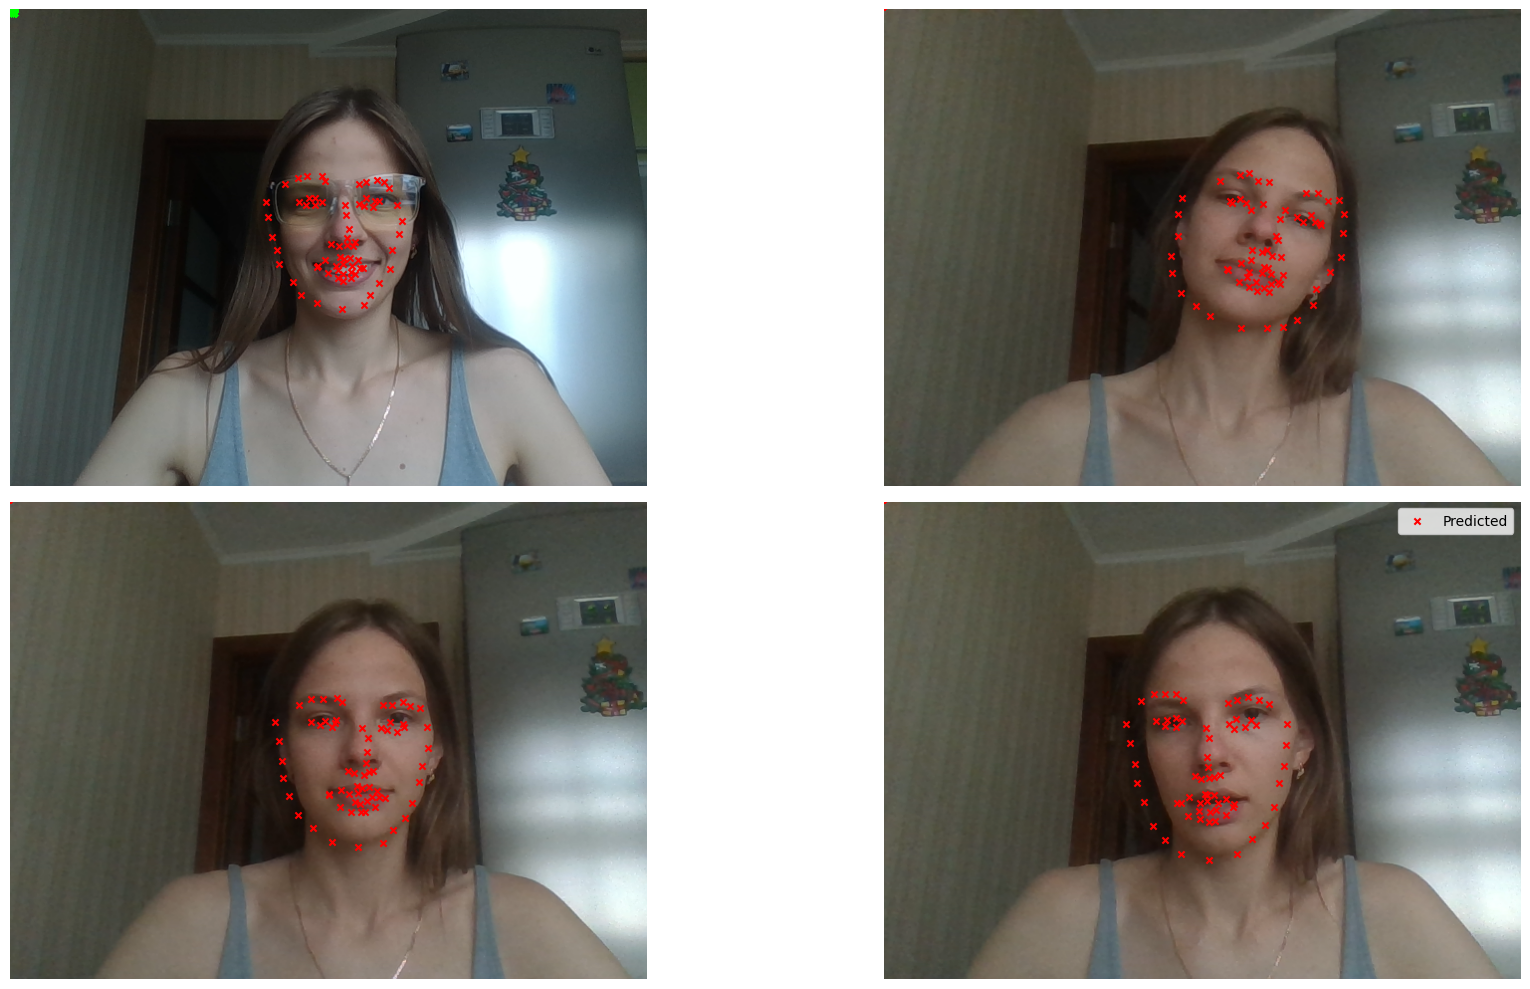

In [ ]:
# create dataset for my own images
new_images_dataset = FaceKeypointsDatasetNoLabels(image_folder='screenshots', transform=test_transform_no_keypoints)

# predictions
results = predict_on_new_images(model, new_images_dataset, device)

# visualisation for predictions
visualize_predictions_no_labels(results)